Simulation Data Generated Successfully

Model Evaluation Results:
               Model         MSE       MAE       RMSE        R2  Train_Time
0  Linear Regression   93.907535  7.087400   9.690590  0.000186    0.002228
1              Ridge   93.871945  7.089869   9.688754  0.000565    0.001825
2              Lasso   93.925952  7.197025   9.691540 -0.000010    0.001827
3      Decision Tree  141.075000  6.655000  11.877500 -0.501997    0.006959
4      Random Forest   68.261340  5.104400   8.262042  0.273235    0.494874
5  Gradient Boosting   68.264419  5.399247   8.262228  0.273203    0.242785
6            XGBoost   69.445058  5.394202   8.333370  0.260633    0.118432
7                KNN   92.842800  6.670000   9.635497  0.011522    0.004623

TOPSIS Ranking:
               Model         MSE       MAE       RMSE        R2  Train_Time  \
6            XGBoost   69.445058  5.394202   8.333370  0.260633    0.118432   
5  Gradient Boosting   68.264419  5.399247   8.262228  0.273203    0.242785

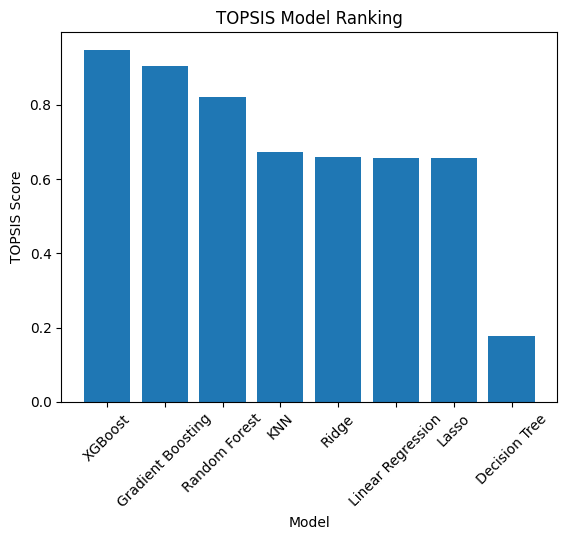


Best Model According to TOPSIS:
XGBoost


In [5]:

#  INSTALL LIBRARIES

!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install scikit-learn
!pip install xgboost

#  IMPORT LIBRARIES

import gymnasium as gym
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# CREATE SIMULATION ENVIRONMENT


env = gym.make("CartPole-v1")

def run_simulation(params):
    obs, _ = env.reset()

    # Override initial state
    env.unwrapped.state = np.array(params)

    total_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    return total_reward

#: GENERATE 1000 SIMULATIONS

data = []

for i in range(1000):
    params = [
        np.random.uniform(-2.4, 2.4),   # cart position
        np.random.uniform(-2, 2),       # cart velocity
        np.random.uniform(-0.2, 0.2),   # pole angle
        np.random.uniform(-2, 2)        # pole velocity
    ]

    reward = run_simulation(params)
    data.append(params + [reward])

columns = ["cart_pos", "cart_vel", "pole_angle", "pole_vel", "reward"]
df = pd.DataFrame(data, columns=columns)

df.to_csv("simulation_data.csv", index=False)

print("Simulation Data Generated Successfully")
df.head()

# STEP 4: PREPARE DATA FOR ML


X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#  DEFINE ML MODELS

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "KNN": KNeighborsRegressor()
}

#  TRAIN MODELS AND COLLECT METRICS

results = []

for name, model in models.items():

    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    results.append([name, mse, mae, rmse, r2, train_time])

results_df = pd.DataFrame(
    results,
    columns=["Model", "MSE", "MAE", "RMSE", "R2", "Train_Time"]
)

print("\nModel Evaluation Results:")
print(results_df)


#  APPLY TOPSIS


def topsis(df, weights, impacts):

    data = df.iloc[:, 1:].values.astype(float)

    # Step 1: Normalize
    norm = data / np.sqrt((data**2).sum(axis=0))

    # Step 2: Apply weights
    weighted = norm * weights

    # Step 3: Ideal best and worst
    ideal_best = []
    ideal_worst = []

    for i in range(len(impacts)):
        if impacts[i] == "+":
            ideal_best.append(np.max(weighted[:, i]))
            ideal_worst.append(np.min(weighted[:, i]))
        else:
            ideal_best.append(np.min(weighted[:, i]))
            ideal_worst.append(np.max(weighted[:, i]))

    ideal_best = np.array(ideal_best)
    ideal_worst = np.array(ideal_worst)

    # Step 4: Distance calculation
    dist_best = np.sqrt(((weighted - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((weighted - ideal_worst)**2).sum(axis=1))

    # Step 5: Score
    score = dist_worst / (dist_best + dist_worst)

    df["TOPSIS_Score"] = score
    df["Rank"] = df["TOPSIS_Score"].rank(ascending=False)

    return df.sort_values("Rank")

# Define weights (sum doesn't have to be 1 but recommended)
weights = np.array([0.2, 0.15, 0.2, 0.35, 0.1])
impacts = ["-", "-", "-", "+", "-"]

final_ranking = topsis(results_df.copy(), weights, impacts)

print("\nTOPSIS Ranking:")
print(final_ranking)

final_ranking.to_csv("model_ranking_topsis.csv", index=False)

# VISUALIZE TOPSIS SCORES

plt.figure()
plt.bar(final_ranking["Model"], final_ranking["TOPSIS_Score"])
plt.xticks(rotation=45)
plt.title("TOPSIS Model Ranking")
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.show()

#  PRINT BEST MODEL


best_model = final_ranking.iloc[0]["Model"]

print("\nBest Model According to TOPSIS:")
print(best_model)

# New Section